In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import itertools
import random
import librosa
from keras import backend as K

## Variational Autoencoders on Poor Sevens

In [2]:
with open('hw5_tr7.pkl', 'rb') as file:
    tr7 = pickle.load(file)
    
with open('hw5_te7.pkl', 'rb') as file:
    te7 = pickle.load(file)

X_train = np.expand_dims(tr7, axis=-1) 
X_test = np.expand_dims(te7, axis=-1)

print(X_train.shape)
print(X_test.shape)

(6265, 28, 28, 1)
(1028, 28, 28, 1)


In [3]:
class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        
        self.latent_dim = 4
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, kernel_size = (5, 5), input_shape=(28,28,1,), activation = 'relu'),
            tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
            tf.keras.layers.Conv2D(64, kernel_size = (2, 2), activation = 'relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='sigmoid')
        ])
        
        self.zmean = tf.keras.layers.Dense(self.latent_dim, activation='sigmoid')
        self.zvar = tf.keras.layers.Dense(self.latent_dim, activation='sigmoid')
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.latent_dim,)),
            tf.keras.layers.Dense(21*21*64, activation='relu'),
            tf.keras.layers.Reshape((21, 21, 64)),
            tf.keras.layers.Conv2DTranspose(64, kernel_size = (2, 2), activation = 'relu'),
            tf.keras.layers.Conv2DTranspose(32, kernel_size = (3, 3), activation = 'relu'),
            tf.keras.layers.Conv2DTranspose(16, kernel_size = (5, 5), activation = 'relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size = (5, 5), padding='SAME')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        z_mean = self.zmean(encoded)
        z_var = self.zvar(encoded)
        epsilon =  K.random_normal(shape=K.shape(z_mean))
        z = z_mean + z_var * epsilon
        # z = z_mean + K.exp(0.5 + z_log_var) * epsilon
        decoded = self.decoder(z)
        return decoded, z, z_mean, z_var

In [4]:
def vae_loss(x, x_decoded_mean, z_mean, z_var):
    reconstruction_loss = K.mean(K.binary_crossentropy(x, x_decoded_mean), axis=[1, 2])
    # print('Reconstruction loss', reconstruction_loss.shape)
    kl_loss = 1 + K.log(K.square(z_var)) - K.square(z_mean) - K.square(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss = kl_loss / ( 28 * 28 )
    # print('kl loss', kl_loss.shape)
    return K.mean(reconstruction_loss + kl_loss)

In [ ]:
VAE = VariationalAutoEncoder()
learning_rate = 0.0005
batch_size = 64
num_epochs = 50
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)
train_loss = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        batch_images = X_train[i:i+batch_size]
        with tf.GradientTape() as tape:
            decoded, z, z_mean, z_log_var = VAE(batch_images)
            loss = vae_loss(batch_images, decoded, z_mean, z_log_var)
            
        gradients = tape.gradient(loss, VAE.trainable_variables)
        optimizer.apply_gradients(zip(gradients, VAE.trainable_variables))
        train_running_loss += loss.numpy()

    train_loss[epoch] = train_running_loss / (len(X_train) // batch_size)
    
    val_running_loss = 0.0
    
    for i in range(0, len(X_test), batch_size):
        val_images = X_test[i:i+batch_size]
        decoded, z, z_mean, z_log_var = VAE(val_images)
        val_loss_value = vae_loss(val_images, decoded, z_mean, z_log_var)
        val_running_loss += val_loss_value.numpy()

    val_loss[epoch] = val_running_loss / (len(X_test) // batch_size)

    # print('Epoch = ', epoch, 'training loss {:.4f}'.format(train_loss[epoch]),'validation loss {:.4f}'.format(val_loss[epoch]))


Text(0, 0.5, 'Loss')

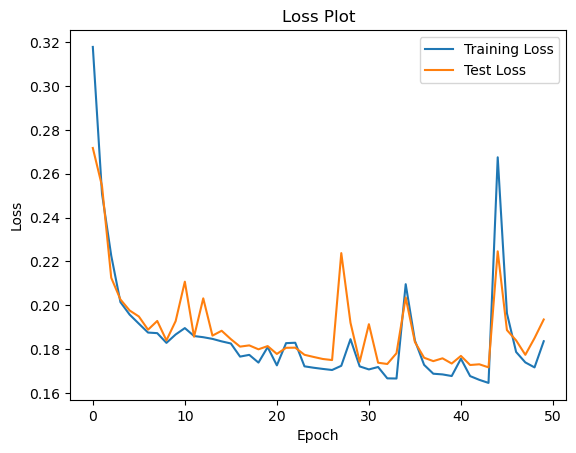

In [6]:
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.title('Loss Plot')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

(10, 28, 28, 1)
1/1 [==============================] - 0s 138ms/step


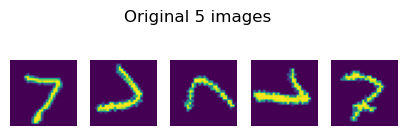

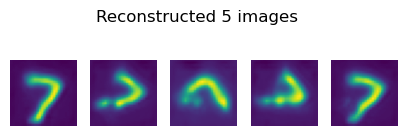

In [7]:
test_data = X_test[0:10]
print(np.shape(test_data))
recons_img, _, _, _ = VAE.predict(test_data) # decoded, z, z_mean, z_var

plt.figure(figsize=(5, 5))
plt.suptitle('Original 5 images')
for i in range(1):
    for j in range(5):
        ax=plt.subplot2grid((5, 5), (i, j))
        ax.imshow(test_data[i*5+j])
        plt.axis('off')
plt.figure(figsize=(5, 5))
plt.suptitle('Reconstructed 5 images')
for i in range(1):
    for j in range(5):
        ax=plt.subplot2grid((5, 5), (i, j))
        ax.imshow(recons_img[i*5+j])
        plt.axis('off')

In [8]:
class DecoderModel(tf.keras.Model):
    def __init__(self, decoder):
        super(DecoderModel, self).__init__()
        self.decoder = decoder

    def call(self, z):
        decoded = self.decoder(z)
        return decoded

In [9]:
test_data = X_test[9:10]
recons_img, z_test, z_mean_test, z_var_test = VAE.predict(test_data)

z_test_flat = z_test[0]
code_vectors = []
for dim in range(len(z_test_flat)):
    for i in np.linspace(-2, 2, 10):
        
        code_vector = z_test_flat.copy().tolist() 
        code_vector[dim] = i
        code_vectors.append(code_vector)


1/1 [==============================] - 0s 15ms/step


In [10]:
decoder_model = DecoderModel(VAE.decoder)
output = decoder_model.predict(code_vectors)

2/2 [==============================] - 0s 5ms/step


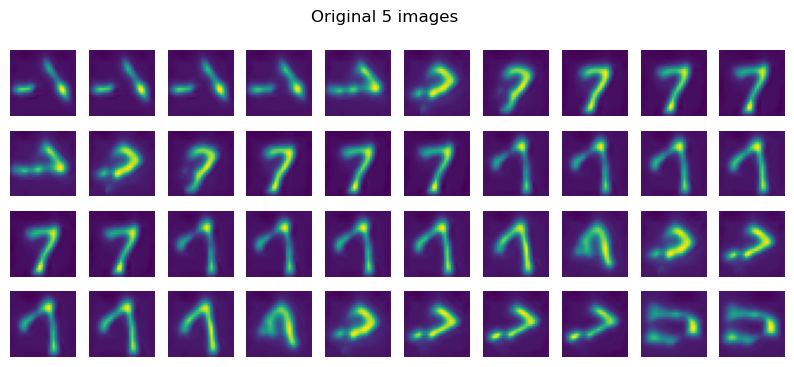

In [11]:
plt.figure(figsize=(10,4))
plt.suptitle('Original 5 images')
for i in range(4):
    for j in range(10):
        ax=plt.subplot2grid((4, 10), (i, j))
        ax.imshow(output[i*4+j])
        plt.axis('off')

From the images produced previously, it seems that one dimension in the latent space governs rotation, while another dimension influences the angle between the horizontal and vertical lines of the number. The first dimention seems to learn the distance between the horizontal and vertical line in number 7.